In [1]:
import sys
import os

# Compute absolute path to the src/ folder
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
src_path = os.path.join(project_root, "src")

# Add src/ to sys.path
sys.path.insert(0, src_path)

# Now you can import the code
from qvarnet import *

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
from qvarnet.models.mlp import MLP

model = MLP(layer_dims=[1,2,1])
model.to(device)
print(model)

MLP(input_dim=1, output_dim=1, hidden_dims=[2], activation=tanh)


In [3]:
from qvarnet.hamiltonians import GeneralHamiltonian, HarmonicOscillator

class TestHamiltonian(GeneralHamiltonian):
    def forward(self, x):
        return -torch.exp(-x**2)
    
hamiltonian = TestHamiltonian(model=model)
hamiltonian.to(device)
print(hamiltonian(torch.tensor([2.0], device=device))) # check that the hamiltonian is working

tensor([-0.0183], device='cuda:0')


device of x: cuda:0
Sample mean: 0.1064
Sample std: 0.9918


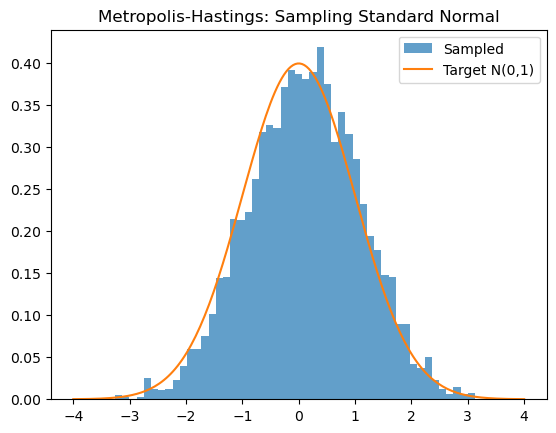

In [4]:
from qvarnet.samplers import MetropolisHastingsSampler

# Simple harmonic oscillator: E(x) = 0.5 * x^2
class HarmonicHamiltonian(GeneralHamiltonian):
    def forward(self, x):
        return 0.5 * x.pow(2).sum(dim=-1)

# Your sampler
sampler = MetropolisHastingsSampler(
    model=HarmonicHamiltonian(),
    n_samples=5000,
    step_size=0.5,
    burn_in=500,
    is_wf=False,
)

sampler.to(device)

# Initial point
x0 = torch.tensor([0.0], device=device)

# Run sampler
samples = sampler(x0)
samples_np = samples.cpu().detach().numpy().flatten()

# Statistics
mean = samples_np.mean()
std = samples_np.std()

print(f"Sample mean: {mean:.4f}")
print(f"Sample std: {std:.4f}")

# Histogram
plt.hist(samples_np, bins=50, density=True, alpha=0.7, label='Sampled')
xs = torch.linspace(-4, 4, 200)
plt.plot(xs, torch.exp(-0.5 * xs**2) / (2 * torch.pi)**0.5, label='Target N(0,1)')
plt.legend()
plt.title("Metropolis-Hastings: Sampling Standard Normal")
plt.show()

In [5]:
def kinetic_energy(psi, x):
    # First derivative
    dpsi_dx = torch.autograd.grad(psi, x, grad_outputs=torch.ones_like(psi),
                                  create_graph=True, retain_graph=True)[0]
    # Second derivative
    d2psi_dx2 = torch.autograd.grad(dpsi_dx, x, grad_outputs=torch.ones_like(dpsi_dx),
                                    create_graph=True, retain_graph=True)[0]
    return -0.5 * d2psi_dx2

def V(x):
    return 0.5 * x**2

In [8]:
from tqdm import tqdm
epochs = 500

model = MLP(layer_dims=[1, 30, 1])
model.to(device)

hamiltonian = HarmonicOscillator(model=model)

hamiltonian.to(device)

sampler = MetropolisHastingsSampler(
    model=model,
    n_samples=500,
    step_size=0.5,
    burn_in=10,
)

# Initial point
x0 = torch.tensor([0.0], device=device, requires_grad=True)

""".view(-1, 1) is used to ensure that x0 is a column vector.
   This is important for the MLP model, which expects input of shape (batch_size, input_dim).
   In this case, input_dim is 1 (since we are dealing with a single variable).
"""

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print("model parameters:")
for name, param in model.named_parameters():
    print(name, param.shape)

x_train = torch.linspace(-4, 4, 1000).view(-1, 1).to(device)
x_train.requires_grad = True

samples = torch.randn(10000, 1).to(device)
samples.requires_grad = True

trapezoid = False

# sampler = torch.compile(sampler)


for epoch in tqdm(range(epochs)):
    optimizer.zero_grad()
    # Run sampler
    samples = sampler(x0)
    samples.requires_grad = True

    # Compute the mean and std of the local energy
    local_energy = hamiltonian(samples)
    psi = model(samples)
    energy = local_energy.mean().item()
    energy_std = local_energy.std().item()
    loss = local_energy.mean()
    
    if trapezoid:
        psi = model(x_train) # computes forward pass
        T = kinetic_energy(psi, x_train)
        V_psi = V(x_train) * psi
        H_psi = T + V_psi

        numerator = torch.trapezoid(torch.conj(psi) * H_psi, x_train, dim=0)
        denominator = torch.trapezoid(psi.pow(2), x_train, dim=0)
        energy = numerator / denominator
        energy = energy
        loss = energy.real
    else:
        mask = torch.abs(samples.squeeze()) > 3  # shape: (batch_size,)
        loss += 1e2 * (psi[mask]**2).sum()
    
    loss.squeeze().backward()
    optimizer.step()
    
print(energy)

model parameters:
model.0.weight torch.Size([30, 1])
model.0.bias torch.Size([30])
model.2.weight torch.Size([1, 30])
model.2.bias torch.Size([1])


  0%|          | 0/500 [00:00<?, ?it/s]

device of x: cuda:0


  0%|          | 1/500 [00:00<04:38,  1.79it/s]

device of x: cuda:0


  0%|          | 2/500 [00:01<04:31,  1.83it/s]

device of x: cuda:0


  1%|          | 3/500 [00:01<04:31,  1.83it/s]

device of x: cuda:0


  1%|          | 4/500 [00:02<04:32,  1.82it/s]

device of x: cuda:0


  1%|          | 5/500 [00:02<04:30,  1.83it/s]

device of x: cuda:0


  1%|          | 6/500 [00:03<04:27,  1.85it/s]

device of x: cuda:0


  1%|▏         | 7/500 [00:03<04:27,  1.84it/s]

device of x: cuda:0


  2%|▏         | 8/500 [00:04<04:25,  1.85it/s]

device of x: cuda:0


  2%|▏         | 9/500 [00:05<04:37,  1.77it/s]


device of x: cuda:0


KeyboardInterrupt: 

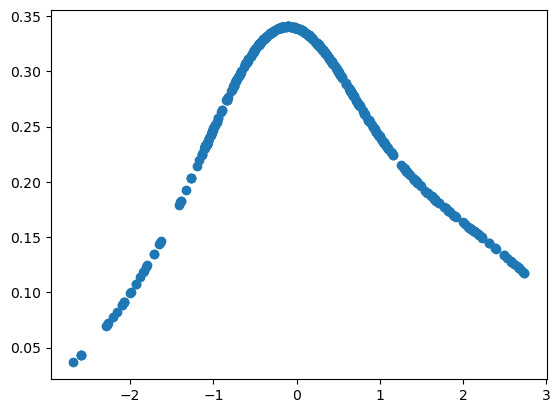

In [ ]:
x_cpu = (samples.cpu().detach().numpy())
y_cpu = model(samples).cpu().detach().numpy()
plt.plot(x_cpu, y_cpu, 'o', label='Sampled')

In [ ]:
for epoch in range(epochs):
        optimizer.zero_grad()

        psi = model(x_train) # computes forward pass
        T = kinetic_energy(psi, x_train)
        V_psi = V(x_train) * psi
        H_psi = T + V_psi


        numerator = torch.trapezoid(torch.conj(psi) * H_psi, x_train, dim=0)
        denominator = torch.trapezoid(torch_abs2(psi), x_train, dim=0)
        energy = numerator / denominator
        energy = energy.real

        loss = energy.real
        if previous_wavefunctions:
            orthogonality_loss = 0
            norm=torch.sqrt(torch.sum(psi**2)*dx)
            psi_normalized=psi/norm
            for prev_psi in previous_wavefunctions:
                overlap = torch.sum(psi_normalized * prev_psi)*dx
                orthogonality_loss += overlap**2  # Penalize the square of the overlap
            overlap_loss=overlap_penalty * orthogonality_loss
            loss +=overlap_loss.real  # Weight the orthogonality loss

        loss.squeeze().backward()
        optimizer.step()

        energy_history.append(energy.item().real)
        
        if save_wavefunction_history and epoch%10==0 :
            norm=torch.sqrt(torch.sum(psi**2)*dx)
            psi_normalized=psi/norm
            wave_function_history.append(psi_normalized.detach().cpu().numpy())

        
        if epoch % print_interval == 0:
            print(f"Epoch {epoch}: Energy = {energy.item().real:.6f}")

In [ ]:
def train_wavefunction(model, x_train, epochs=1000, lr=1e-2, print_interval=100, save_wavefunction_history=False, previous_wavefunctions=None, overlap_penalty=1e2, callback=None):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    dx = (x_train[1] - x_train[0]).real  # Real-valued step size

    energy_history = []

    if save_wavefunction_history:
        wave_function_history = []
        psi = model(x_train)
        norm=torch.sqrt(torch.sum(psi**2)*dx)
        psi_normalized=psi/norm
        wave_function_history.append(psi_normalized.detach().cpu().numpy())
    else:
        wave_function_history = None

    for epoch in range(epochs):
        optimizer.zero_grad()

        psi = model(x_train) # computes forward pass
        T = kinetic_energy(psi, x_train)
        V_psi = V(x_train) * psi
        H_psi = T + V_psi


        numerator = torch.trapezoid(torch.conj(psi) * H_psi, x_train, dim=0)
        denominator = torch.trapezoid(torch_abs2(psi), x_train, dim=0)
        energy = numerator / denominator
        energy = energy.real

        loss = energy.real
        if previous_wavefunctions:
            orthogonality_loss = 0
            norm=torch.sqrt(torch.sum(psi**2)*dx)
            psi_normalized=psi/norm
            for prev_psi in previous_wavefunctions:
                overlap = torch.sum(psi_normalized * prev_psi)*dx
                orthogonality_loss += overlap**2  # Penalize the square of the overlap
            overlap_loss=overlap_penalty * orthogonality_loss
            loss +=overlap_loss.real  # Weight the orthogonality loss

        loss.squeeze().backward()
        optimizer.step()

        energy_history.append(energy.item().real)
        
        if save_wavefunction_history and epoch%10==0 :
            norm=torch.sqrt(torch.sum(psi**2)*dx)
            psi_normalized=psi/norm
            wave_function_history.append(psi_normalized.detach().cpu().numpy())

        
        if epoch % print_interval == 0:
            print(f"Epoch {epoch}: Energy = {energy.item().real:.6f}")
        
        if callback is not None:
            callback(epoch, energy.item(), model)

            # If the callback indicates stopping, break the training loop
            if hasattr(callback, 'stop_training') and callback.stop_training:
              model.load_state_dict(callback.best_model_state)
              print(f"Training stopped early at epoch {epoch+1}")
              break

            
    with torch.no_grad():
        psi = model(x_train)
        psi_cpu = psi.cpu().numpy()
        energy = energy.item()
        # Normalize the wavefunction
        normalization = torch.sqrt(torch.trapz(torch_abs2(psi), x_train, dim=0))
        normalization_cpu = normalization.cpu().numpy()
        psi_normalized = psi_cpu / normalization_cpu
        psi_torch_normalized = psi / normalization


    return psi_normalized, energy,energy_history,wave_function_history,psi_torch_normalized